In [1]:
import time
import numpy as np
import math
import matplotlib.pyplot as plt
from multiprocessing import Pool
import random
import timeit
import copy
import pandas as pd
import warnings
import scipy.integrate as integrate
warnings.filterwarnings('ignore')
import os
import sys
sys.path.append(os.path.abspath("../test/"))
from DrLi_gorgeous_plotlib import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib import cm #color map
from matplotlib.ticker import FormatStrFormatter # set decimals in ticks
from matplotlib import rc

font=15
fontfml='Times New Roman'
plt.rcParams['font.size'] = font
plt.rcParams['font.family'] = fontfml
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['mathtext.rm'] =fontfml
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
#plt.rcParams['text.usetex'] = True

# remove default bold font setting--run only on Linux server
import matplotlib as mpl
#del mpl.font_manager.weight_dict['rome']
#mpl.font_manager._rebuild()

### Results of shortwave

In [3]:
data = np.genfromtxt('../data/profiles/ASTMG173.csv', delimiter=',', skip_header=1,  # in wavenumber basis
                     names=['wavelength', 'column2', 'column3', '37d_irrdiance'])
nu = np.arange(2500,33333+5,5)  # cm-1
ref_lam = data['wavelength'][1:]  # nm
ref_E = data['37d_irrdiance'][1:]  # Direct+circumsolar W/[m2*nm]
ref_E_nu=-ref_E*ref_lam**2/1e7  # W/[m2*nm-1] to W/[m2*cm-1]
F_dw_os = -np.interp(-nu, -1e7/ref_lam, ref_E_nu)  # W/[m2*cm-1] 

In [4]:
import scipy.integrate as integrate

I2 = integrate.trapz(F_dw_os, nu)
I1 = integrate.trapz(ref_E,ref_lam)
F_dw0 = I2
print(f"{I2} W/m-2")
print(I1)

900.1446337433081 W/m-2
900.139329284215


### Flux list

Emergy = 900 w/m2 * 4 m2 = 3600 W

In [5]:
import numpy as np
import os 
import scipy.integrate as integrate

path = "./SolarDepth/"
Fls = os.listdir(path) 

Fls = [s for s in Fls if s.endswith('SWresults_200layer_1000bundle_diffuse.npy')]
len(Fls)

1

In [6]:
result = np.load(path+Fls[0],allow_pickle=True)
#result = np.load("./theta/6layel_SW_6layer_100bundle_0theta.npy",allow_pickle=True)
N_layer = result.item().get('F_n_abs').shape[0]
nu = np.arange(2500,33333+5,5)  # cm-1
top = 2.0
z = np.linspace(0,top,N_layer)
level = np.arange(N_layer)
za = z[:-1]+(z[1:]-z[:-1])/2
result.item().keys()

dict_keys(['F_n_uw', 'F_n_dw', 'F_n_abs', 'F_n_sca', 'F_n_abs_leftn', 'F_n_abs_rights', 'F_n_abs_fronte', 'F_n_abs_backw'])

In [7]:
notice = f"N_layer = bottom + {N_layer} + top of water surface \n"
print(notice)

print("-------------------------------------------")
print("Flus absorbed by each level\n")
temp = result.item().get('F_n_abs')
F_abs = integrate.trapz(temp, nu, axis=1)
print(f'Total flux={np.sum(F_abs)}\n')

#print(f"F_abs absorbed by each level: irradiance[w/m2]\n {F_abs}")

print("--------------------------------------------")
print("Flus absorbed by edge")

F_edge = []
items = ['F_n_abs_rights','F_n_abs_leftn','F_n_abs_fronte','F_n_abs_backw']
for item in items:
    print(item)
    temp = result.item().get(item)
    print(nu.shape)
    print(len(temp))
    temp2=(integrate.trapz(temp, nu, axis=1))
    F_edge.append(temp2)
    print(f"{item}: sum = {np.sum(temp2)}[w/m2]")
    #print(f"each level = {temp2}\n")

print("--------------------------------------------")
print("Flus scattered")
temp = result.item().get('F_n_sca')
F_sca = integrate.trapz(temp, nu, axis=1)
print(f'F_scat: {np.sum(F_sca)}irradiance[w/m2]') #\n{F_sca} [w/m2]\n')

N_layer = bottom + 202 + top of water surface 

-------------------------------------------
Flus absorbed by each level

Total flux=800.1192501831799

--------------------------------------------
Flus absorbed by edge
F_n_abs_rights
(6168,)
202
F_n_abs_rights: sum = 11.958331152138875[w/m2]
F_n_abs_leftn
(6168,)
202
F_n_abs_leftn: sum = 0.25194133426657705[w/m2]
F_n_abs_fronte
(6168,)
202
F_n_abs_fronte: sum = 0.13187364404845264[w/m2]
F_n_abs_backw
(6168,)
202
F_n_abs_backw: sum = 18.335070318987338[w/m2]
--------------------------------------------
Flus scattered
F_scat: 24.24284625818909irradiance[w/m2]


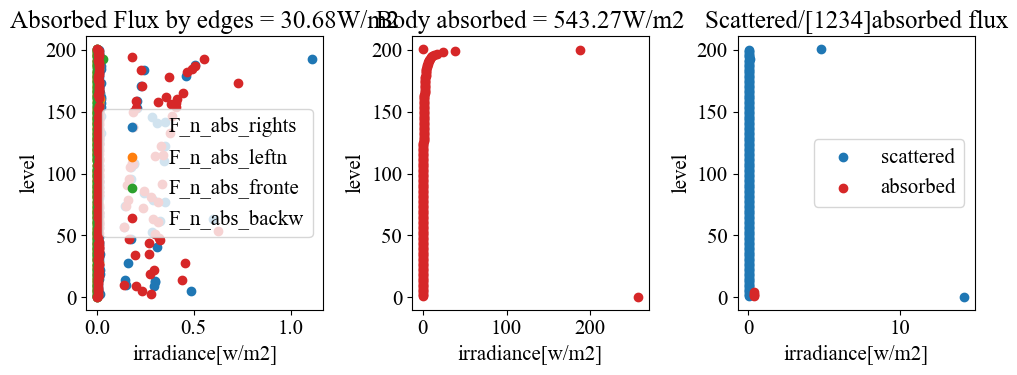

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 4))

# figure 1
F_edge_left = F_edge[0]
for i in range(len(items)):
    ax1.scatter(F_edge[i], level, label=items[i])
ax1.set_title("Absorbed Flux by edges = {:0.2f}W/m2".format(np.sum(F_edge)))
ax1.set_ylabel("level")
ax1.set_xlabel('irradiance[w/m2]')
ax1.legend()

# figure2
ax2.scatter(F_abs, level, color="C3")
ax2.set_title("Body absorbed = {:0.2f}W/m2".format(np.sum(F_abs[1:-1])))
ax2.set_ylabel("level")
ax2.set_xlabel('irradiance[w/m2]')

# figure 2
ax3.scatter(F_sca, level, label="scattered")
ax3.scatter(F_abs[1:5], level[1:5], label="absorbed",color="C3")
ax3.legend()
ax3.set_title("Scattered/[1234]absorbed flux")
ax3.set_ylabel("level")
ax3.set_xlabel('irradiance[w/m2]')

plt.tight_layout()
plt.show()

In [9]:
F_edge = []
items = ['F_n_abs_rights','F_n_abs_leftn','F_n_abs_fronte','F_n_abs_backw']
edge_abs = 0
edge_spectrum = 0
for item in items:
    temp = result.item().get(item)
    temp2=integrate.trapz(temp, nu, axis=1)
    edge_spectrum += temp
    edge_abs += np.sum(temp2)
print(f"total incident : {F_dw0} W/m2")
temp = result.item().get("F_n_dw")
F_dw = integrate.trapz(temp, nu, axis=1)
reflec = (1 - F_dw[-1]/F_dw0)*100

total incident : 900.1446337433081 W/m2


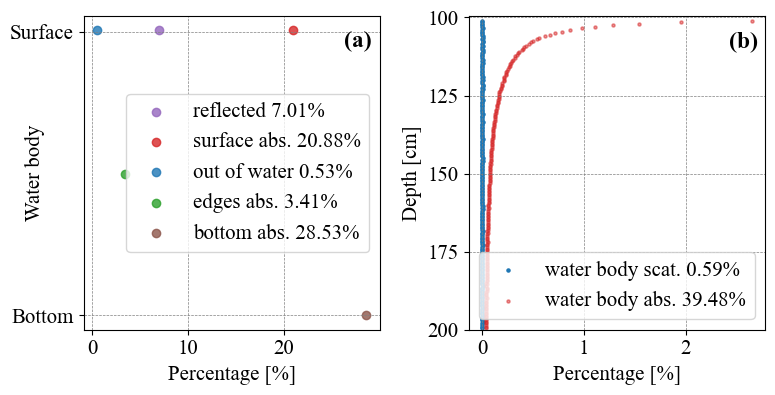

In [10]:
plt.rcParams['font.family'] = 'Times New Roman'  # For example, set font to Arial
plt.rcParams['font.size'] = 15  # 
font = 15
fontfml = 'Times New Roman'
fig, (ax2, ax3) = plt.subplots(ncols=2, figsize=(8, 4.2))

# figure1
rf = reflec
ax2.scatter(rf, level[-1], color="C4",alpha=0.8,
            label = "reflected {:0.2f}%".format(rf))
ax2.scatter(F_abs[-2]/F_dw0*100, level[-1], color="C3",alpha=0.8,
            label = "surface abs. {:0.2f}%".format(F_abs[-2]/F_dw0*100))
ax2.scatter(F_sca[-1]/F_dw0*100, level[-1], color="C0",alpha=0.8,
            label="out of water {:0.2f}%".format(F_sca[-1]/F_dw0*100))
ax2.scatter(edge_abs/F_dw0*100, level[100], color="C2",alpha=0.8,
            label = "edges abs. {:0.2f}%".format(edge_abs/F_dw0*100))
ax2.scatter(F_abs[0]/F_dw0*100, level[0], color="C5",alpha=0.8,
            label = "bottom abs. {:0.2f}%".format(F_abs[0]/F_dw0*100))

#ax2.set_title("Diffuse sunlights's radiation distribution")
ax2.set_ylabel("Water body",labelpad=-25)
ax2.set_yticks([0,200])
ax2.set_yticklabels(['Bottom','Surface'])
ax2.legend()
ax2.grid(True)
ax2.grid(color='grey', linestyle='--', linewidth=0.5)
#ax2.set_xlim([-5,50])
#ax2.set_xticks([-5,15,30,45,50])
ax2.set_xlabel('Percentage [%]')

# figure 2
ax3.scatter(F_sca[1:N_layer-3]/F_dw0*100, level[1:N_layer-3],s=5,
            label="water body scat. {:0.2f}%".format(np.sum(F_sca[1:-2])/F_dw0*100))
ax3.scatter(F_abs[1:N_layer-3]/F_dw0*100, level[1:N_layer-3], alpha=0.5,s=5,
            label="water body abs. {:0.2f}%".format(np.sum(F_abs[1:-2])/F_dw0*100),color="C3")
ax3.legend(loc="lower right")
ax3.set_ylim([0,201])
ax3.set_yticklabels(np.arange(200,0-25,-25))
ax3.grid(True)
ax3.grid(color='grey', linestyle='--', linewidth=0.5)
#ax3.set_title("Water body excluding the surface")
ax3.set_ylabel("Depth [cm]")
ax3.set_xlabel('Percentage [%]')


ax2.text(0.88, 0.9, '(a)', transform=ax2.transAxes,fontsize=font+2,fontfamily=fontfml, weight='bold')
ax3.text(0.88, 0.9, '(b)', transform=ax3.transAxes,fontsize=font+2,fontfamily=fontfml, weight='bold')

plt.tight_layout()
#plt.savefig("SW_abs_ab.png",dpi=300,bbox_inches='tight')
plt.show()

### spectrum plot

In [11]:
nu = np.arange(2500,33333+5,5)  # nm-1
temp1 = result.item().get('F_n_abs')

#### wave number

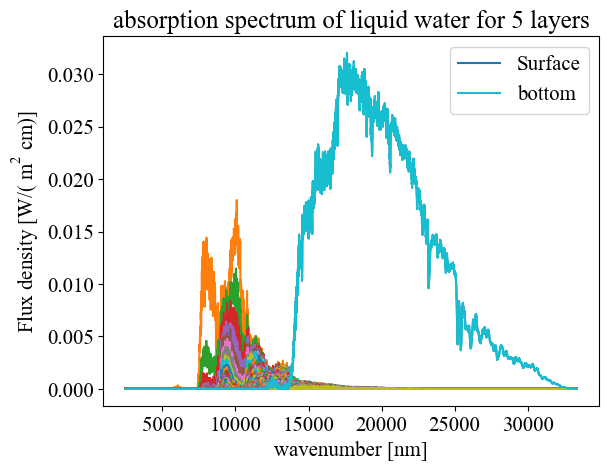

In [12]:
l = len(level)
plt.plot(nu, temp1[0], label = f"Surface")
for i in range(3, l-1):
    plt.plot(nu, temp1[l-i]) #, label = f"layer {l-i}")
plt.plot(nu, temp1[0], label = "bottom")
plt.legend()
plt.ylabel("Flux density [W/( m$^{2}$ cm)]")
plt.xlabel("wavenumber [nm]")
plt.title("absorption spectrum of liquid water for 5 layers")
plt.show()

In [13]:
l = len(level)
temp1 = result.item().get('F_n_abs')
F_dw00 = F_dw0/5

In [14]:
path2 = "./solarangle/"  # angle
Fls2 = os.listdir(path2)
Fls2 = [s for s in Fls2 if s.endswith('SW_results_200layer_1000bundle_0theta.npy')]
result2 = np.load(path2+Fls2[0],allow_pickle=True)
temp = result2.item().get('F_n_abs')
F_abs2 = integrate.trapz(temp, nu, axis=1)
F_edge = []
items = ['F_n_abs_rights','F_n_abs_leftn','F_n_abs_fronte','F_n_abs_backw']
for item in items:
    temp = result.item().get(item)
    temp2=(integrate.trapz(temp, nu, axis=1))
    F_edge.append(temp2)
temp = result2.item().get("F_n_dw")
F_dw2 = integrate.trapz(temp, nu, axis=1)
reflec2 = (1 - F_dw2[-1]/F_dw0)*100

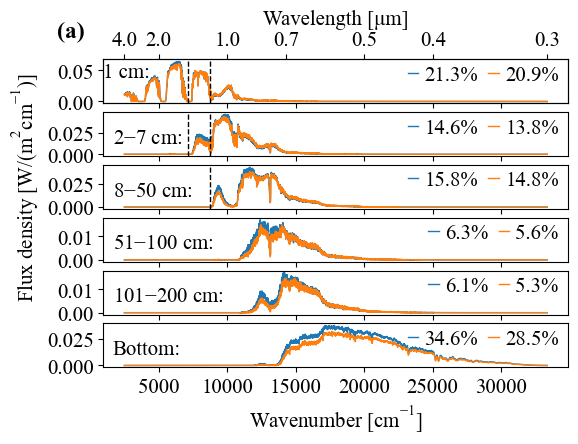

In [15]:
plt.rcParams['font.family'] = 'Times New Roman'  # For example, set font to Arial
plt.rcParams['font.size'] = 15  # 
font = 15
fontfml = 'Times New Roman'
fig, axs = plt.subplots(6,figsize=(6, 4))
#---------------------------
temp2 = result2.item().get('F_n_abs')
# surface
percent = "{:0.1f}%".format(np.sum(temp2[200])/F_dw00*100)
axs[0].plot(nu, temp2[-2],  linewidth=1,label = f"{percent}") #'Direct 0$\degree$'
axs[0].set_xticklabels([])
axs[0].text(0.0, 0.6, '1 cm:', transform=axs[0].transAxes)
axs[0].text(-0.1, 1.5, '(a)', transform=axs[0].transAxes,fontsize=font+2,fontfamily=fontfml, weight='bold')
 
b_lims=np.array([2500, 5000, 10000, 14285, 20000, 25000, 33333])
# add another x-axis for wavelength
new_tick_locations = b_lims
ax3=lambda_axis(axs[0],new_tick_locations,font,fontfml,True)
xlabel='Wavelength ['+ u'\u03bc'+'m]'
ax3.set_xlabel(xlabel,fontsize=font,family=fontfml)

# 2-7 cm
percent = "{:0.1f}%".format(np.sum(temp2[193:200])/F_dw00*100)
axs[1].plot(nu, np.sum(temp2[193:200],axis=0), linewidth=1,
            label = rf"{percent}")
axs[1].text(0.02, 0.3, '2$-$7 cm:', transform=axs[1].transAxes)
axs[1].set_xticklabels([])
axs[1].legend(loc="upper right",handlelength=0.5,frameon=False, edgecolor='none')

# 7 -50
percent = "{:0.1f}%".format(np.sum(temp2[151:193])/F_dw00*100)
axs[2].plot(nu, np.sum(temp2[151:193],axis=0), linewidth=1,
            label = rf"{percent}")
axs[2].text(0.02, 0.3, '8$-$50 cm:', transform=axs[2].transAxes)
axs[2].set_xticklabels([])
axs[2].legend(loc="upper right",handlelength=0.5,frameon=False, edgecolor='none')
# 50 -100
percent = "{:0.1f}%".format(np.sum(temp2[101:151])/F_dw00*100)
axs[3].plot(nu, np.sum(temp2[101:151],axis=0),  linewidth=1,
            label = rf"{percent}")
axs[3].text(0.02, 0.3, '51$-$100 cm:', transform=axs[3].transAxes)
axs[3].set_xticklabels([])
axs[3].legend(loc="upper right",handlelength=0.5,frameon=False, edgecolor='none')
# 100 - 200
percent = "{:0.1f}%".format(np.sum(temp2[1:101])/F_dw00*100)
axs[4].plot(nu, np.sum(temp2[1:101],axis=0),  linewidth=1,
            label = rf"{percent}") 
axs[4].text(0.02, 0.3, '101$-$200 cm:', transform=axs[4].transAxes)
axs[4].set_xticklabels([])
axs[4].legend(loc="upper right",handlelength=0.5,frameon=False, edgecolor='none')

# Bottom
percent = "{:0.1f}%".format(np.sum(temp2[0])/F_dw00*100)
axs[5].plot(nu, temp2[0], linewidth=1, label=f"{percent}")
axs[5].text(0.02, 0.3, 'Bottom:', transform=axs[5].transAxes)
# axs[5].legend(loc="upper left",handlelength=0.5,frameon=False, edgecolor='none')#fig.suptitle("Absorption spectrum of 5 layers liquid water")

# ==========================# 
# surface
percent = "{:0.1f}%".format(np.sum(temp1[200])/F_dw00*100)
axs[0].plot(nu, temp1[-2],  linewidth=1,label = f"{percent}") #'Diffuse'
axs[0].set_xticklabels([])
axs[0].legend(loc="upper right",frameon=False, edgecolor='none',bbox_to_anchor=(1.02, 1.3),
              ncol=2,columnspacing=0.5,handlelength=0.5,handletextpad=0.3)

xlabel='Wavelength ['+ u'\u03bc'+'m]'
ax3.set_xlabel(xlabel,fontsize=font,family=fontfml)

# 2-7 cm
percent = "{:0.1f}%".format(np.sum(temp1[193:200])/F_dw00*100)
axs[1].plot(nu, np.sum(temp1[193:200],axis=0), linewidth=1,
            label = rf"{percent}")
axs[1].set_xticklabels([])
axs[1].legend(loc="upper right",frameon=False, edgecolor='none',bbox_to_anchor=(1.02, 1.3),
              ncol=2,columnspacing=0.5,handlelength=0.5,handletextpad=0.3)
# 7 -50
percent = "{:0.1f}%".format(np.sum(temp1[151:193])/F_dw00*100)
axs[2].plot(nu, np.sum(temp1[151:193],axis=0), linewidth=1,
            label = rf"{percent}")
axs[2].set_xticklabels([])
axs[2].legend(loc="upper right",frameon=False, edgecolor='none',bbox_to_anchor=(1.02, 1.3),
              ncol=2,columnspacing=0.5,handlelength=0.5,handletextpad=0.3)
# 50 -100
percent = "{:0.1f}%".format(np.sum(temp1[101:151])/F_dw00*100)
axs[3].plot(nu, np.sum(temp1[101:151],axis=0),  linewidth=1,
            label = rf"{percent}")
axs[3].set_xticklabels([])
axs[3].legend(loc="upper right",frameon=False, edgecolor='none',bbox_to_anchor=(1.02, 1.3),
              ncol=2,columnspacing=0.5,handlelength=0.5,handletextpad=0.3)
# 100 - 200
percent = "{:0.1f}%".format(np.sum(temp1[1:101])/F_dw00*100)
axs[4].plot(nu, np.sum(temp1[1:101],axis=0),  linewidth=1,
            label = rf"{percent}") 
axs[4].set_xticklabels([])
axs[4].legend(loc="upper right",frameon=False, edgecolor='none',bbox_to_anchor=(1.02, 1.3),
              ncol=2,columnspacing=0.5,handlelength=0.5,handletextpad=0.3)

# Bottom
percent = "{:0.1f}%".format(np.sum(temp1[0])/F_dw00*100)
axs[5].plot(nu, temp1[0], linewidth=1, label=f"{percent}")
axs[5].legend(loc="upper right",frameon=False, edgecolor='none',bbox_to_anchor=(1.02, 1.3),
              ncol=2,columnspacing=0.5,handlelength=0.5,handletextpad=0.3)
axs[5].set_xlabel("Wavenumber [cm$^{-1}$]",fontsize=font,fontfamily=fontfml)
#axs[5].set_xlim([0,35000])
axs[2].set_ylabel(r"Flux density [W/(m$^{2}$cm$^{-1}$)]")

axs[0].axvline(x=1/1.14*1e4, color='k', linestyle='--',linewidth=1)
axs[1].axvline(x=1/1.14*1e4, color='k', linestyle='--',linewidth=1)
axs[2].axvline(x=1/1.14*1e4, color='k', linestyle='--',linewidth=1)

axs[0].axvline(x=1/1.4*1e4, color='k', linestyle='--',linewidth=1)
axs[1].axvline(x=1/1.4*1e4, color='k', linestyle='--',linewidth=1)

fig_dir = './../figure/'
#plt.savefig(fig_dir+"SW_abs_diffuse.png",dpi=300,bbox_inches='tight',transparent=True)

plt.show()

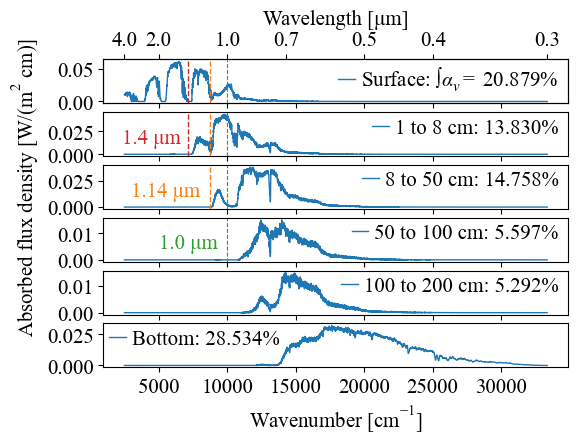

In [108]:
plt.rcParams['font.family'] = 'Times New Roman'  # For example, set font to Arial
plt.rcParams['font.size'] = 15  # 
font = 15
fontfml = 'Times New Roman'
fig, axs = plt.subplots(6,figsize=(6, 4))
#fig.suptitle("Absorption spectrum of 5 layers liquid water")

# 1
percent = "{:0.3f}%".format(np.sum(temp1[-2])/F_dw00*100)
axs[0].plot(nu, temp1[-2],  linewidth=1,label = fr"Surface: $\int\alpha_\nu=$ {percent}")
axs[0].legend(loc="upper right",frameon=False, edgecolor='none',bbox_to_anchor=(1.02, 1.3),
              ncol=2,columnspacing=0.5,handlelength=0.8,handletextpad=0.3)
#axs[0].text(0.01, 0.6, '(a)', transform=axs[0].transAxes,fontsize=font+2,fontfamily=fontfml, weight='bold')

b_lims=np.array([2500, 5000, 10000, 14285, 20000, 25000, 33333])
# add another x-axis for wavelength
new_tick_locations = b_lims
ax3=lambda_axis(axs[0],new_tick_locations,font,fontfml,True)
ax3.set_xlabel('Wavelength ['+ u'\u03bc'+'m]',fontsize=font,family=fontfml)

# 2-7
percent = "{:0.3f}%".format(np.sum(temp1[193:200])/F_dw00*100)
axs[1].plot(nu, np.sum(temp1[193:200],axis=0), linewidth=1,
            label = rf"1 to 8 cm: {percent}")
axs[1].legend(loc="upper right",frameon=False, edgecolor='none',bbox_to_anchor=(1.02, 1.3),
              ncol=2,columnspacing=0.5,handlelength=0.8,handletextpad=0.3)
# 7-50
percent = "{:0.3f}%".format(np.sum(temp1[151:193])/F_dw00*100)
axs[2].plot(nu, np.sum(temp1[151:193],axis=0),  linewidth=1,
            label = rf"8 to 50 cm: {percent}")
axs[2].legend(loc="upper right",frameon=False, edgecolor='none',bbox_to_anchor=(1.02, 1.3),
              ncol=2,columnspacing=0.5,handlelength=0.8,handletextpad=0.3)
# 50-100
percent = "{:0.3f}%".format(np.sum(temp1[101:151])/F_dw00*100)
axs[3].plot(nu, np.sum(temp1[101:151],axis=0),  linewidth=1,
            label = rf"50 to 100 cm: {percent}") 
axs[3].legend(loc="upper right",frameon=False, edgecolor='none',bbox_to_anchor=(1.02, 1.3),
              ncol=2,columnspacing=0.5,handlelength=0.8,handletextpad=0.3)
# 100-200
percent = "{:0.3f}%".format(np.sum(temp1[1:101])/F_dw00*100)
axs[4].plot(nu, np.sum(temp1[1:101],axis=0),  linewidth=1,
            label = rf"100 to 200 cm: {percent}") 
axs[4].legend(loc="upper right",frameon=False, edgecolor='none',bbox_to_anchor=(1.02, 1.3),
              ncol=2,columnspacing=0.5,handlelength=0.8,handletextpad=0.3)
# Bottom
percent = "{:0.3f}%".format(np.sum(temp1[0])/F_dw00*100)
axs[5].plot(nu, temp1[0], linewidth=1, label=f"Bottom: {percent}")
axs[5].legend(loc="upper right",frameon=False, edgecolor='none',bbox_to_anchor=(0.42, 1.3),
              ncol=2,columnspacing=0.5,handlelength=0.8,handletextpad=0.3)
axs[5].set_xlabel("Wavenumber [cm$^{-1}$]",fontsize=font,fontfamily=fontfml)
#axs[5].set_xlim([0,33333])
axs[2].set_ylabel(r"Absorbed flux density [W/(m$^{2}$ cm)]")

axs[0].axvline(x=1/1.4*1e4, color='C3', linestyle='--',linewidth=1)
axs[1].axvline(x=1/1.4*1e4, color='C3', linestyle='--',linewidth=1)
axs[1].text(0.04, 0.3, '1.4 '+u'\u03bc'+'m', color='C3', transform=axs[1].transAxes)

axs[0].axvline(x=1/1.14*1e4, color='C1', linestyle='--',linewidth=1)
axs[1].axvline(x=1/1.14*1e4, color='C1', linestyle='--',linewidth=1)
axs[2].axvline(x=1/1.14*1e4, color='C1', linestyle='--',linewidth=1)
axs[2].text(0.06, 0.3, '1.14 '+u'\u03bc'+'m', color='C1', transform=axs[2].transAxes)

axs[0].axvline(x=1/1.*1e4, color='C2', linestyle='--',linewidth=0.8)
axs[1].axvline(x=1/1.*1e4, color='C2', linestyle='--',linewidth=0.8)
axs[2].axvline(x=1/1.*1e4, color='C2', linestyle='--',linewidth=0.8)
axs[3].axvline(x=1/1.*1e4, color='C2', linestyle='--',linewidth=0.8)
axs[3].text(0.12, 0.3, '1.0 '+u'\u03bc'+'m', color='C2', transform=axs[3].transAxes)

fig_dir = './../figure/'
plt.savefig(fig_dir+"SW_spec_chara.png",dpi=300,bbox_inches='tight')
plt.show()

#### wavelength

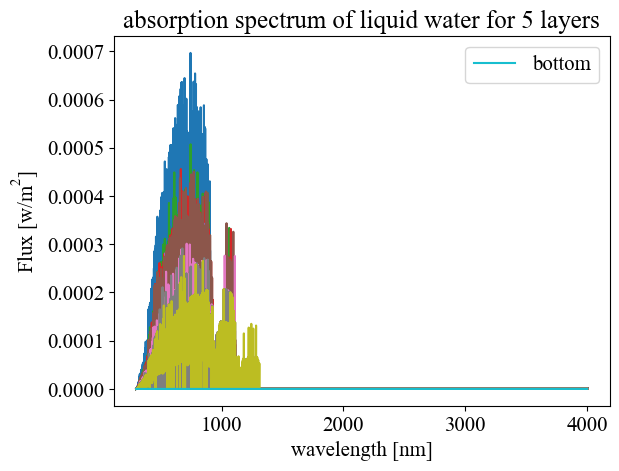

In [39]:
ax = plt.subplot()
lam = 1/nu*1e7 
for i in range(1, len(level)-2):
    #F_lam = temp[6-i]*1e7/lam**2  # cm-1 to nm
    plt.plot(lam, temp[i])#, label = f"layer {6-i}")
plt.plot(lam, temp[0], label = "bottom")
plt.legend()
plt.ylabel("Flux [w/m$^2$]")
plt.xlabel("wavelength [nm]")
plt.title("absorption spectrum of liquid water for 5 layers")
plt.show()

### 2d_GHI

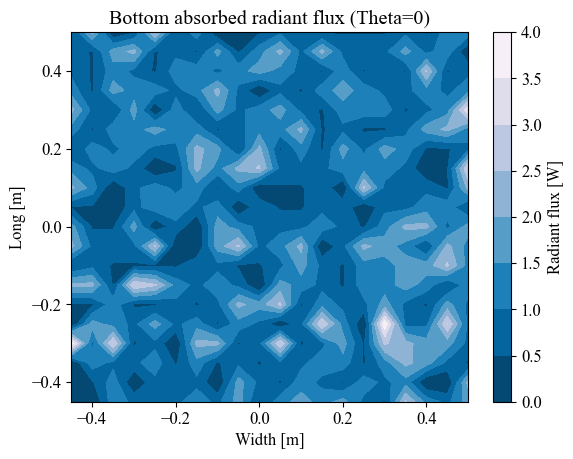

In [168]:
import matplotlib.pyplot as mpl
plt.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['font.size'] = 12
path = "./figure/"

fig, ax = plt.subplots()
# 画contour图
cs = ax.contourf(x/100, y/100, z,cmap=cm.PuBu_r)
#CS = ax.contour(x, y, z)
cbar = fig.colorbar(cs)
plt.title(f'Bottom absorbed radiant flux (Theta=0)')
cbar.set_label('Radiant flux [W]')

plt.xlabel('Width [m]')
plt.ylabel('Long [m]')

# Display the plot
plt.savefig("theta0_bottom.png",dpi=300)
plt.show()

## Input irrdiance spectrum for LW SW

In [42]:
fig_dir = "../figure/"
data = np.genfromtxt('../data/profiles/ASTMG173.csv', delimiter=',', skip_header=1,  # in wavenumber basis
                     names=['wavelength', 'column2', 'column3', '37d_irrdiance'])
nu2 = np.arange(2500,35000,3)  # cm-1
ref_lam = data['wavelength'][1:]  # nm
ref_E = data['37d_irrdiance'][1:]  # Direct+circumsolar W/[m2*nm]
ref_E_nu=-ref_E*ref_lam**2/1e7  # W/[m2*nm-1] to W/[m2*cm-1]
F_dw_os2 = -np.interp(-nu2, -1e7/ref_lam, ref_E_nu)  # W/[m2*cm-1] 

In [43]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys, os
sys.path.append(os.path.abspath("../test/"))
from DrLi_gorgeous_plotlib import *

In [44]:
dnu=0.1
b_lims=np.array([2500,10000, 14285, 20000, 25000, 33333])
bands=[[dnu,b_lims[0]],[b_lims[0],b_lims[2]],[b_lims[2],b_lims[4]], [b_lims[4],b_lims[5]]]
band_labels = ['330K','infrared band','visible','UV band']

In [45]:
[c for c in np.arange(0.00,0.07,0.01, dtype=float)]

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]

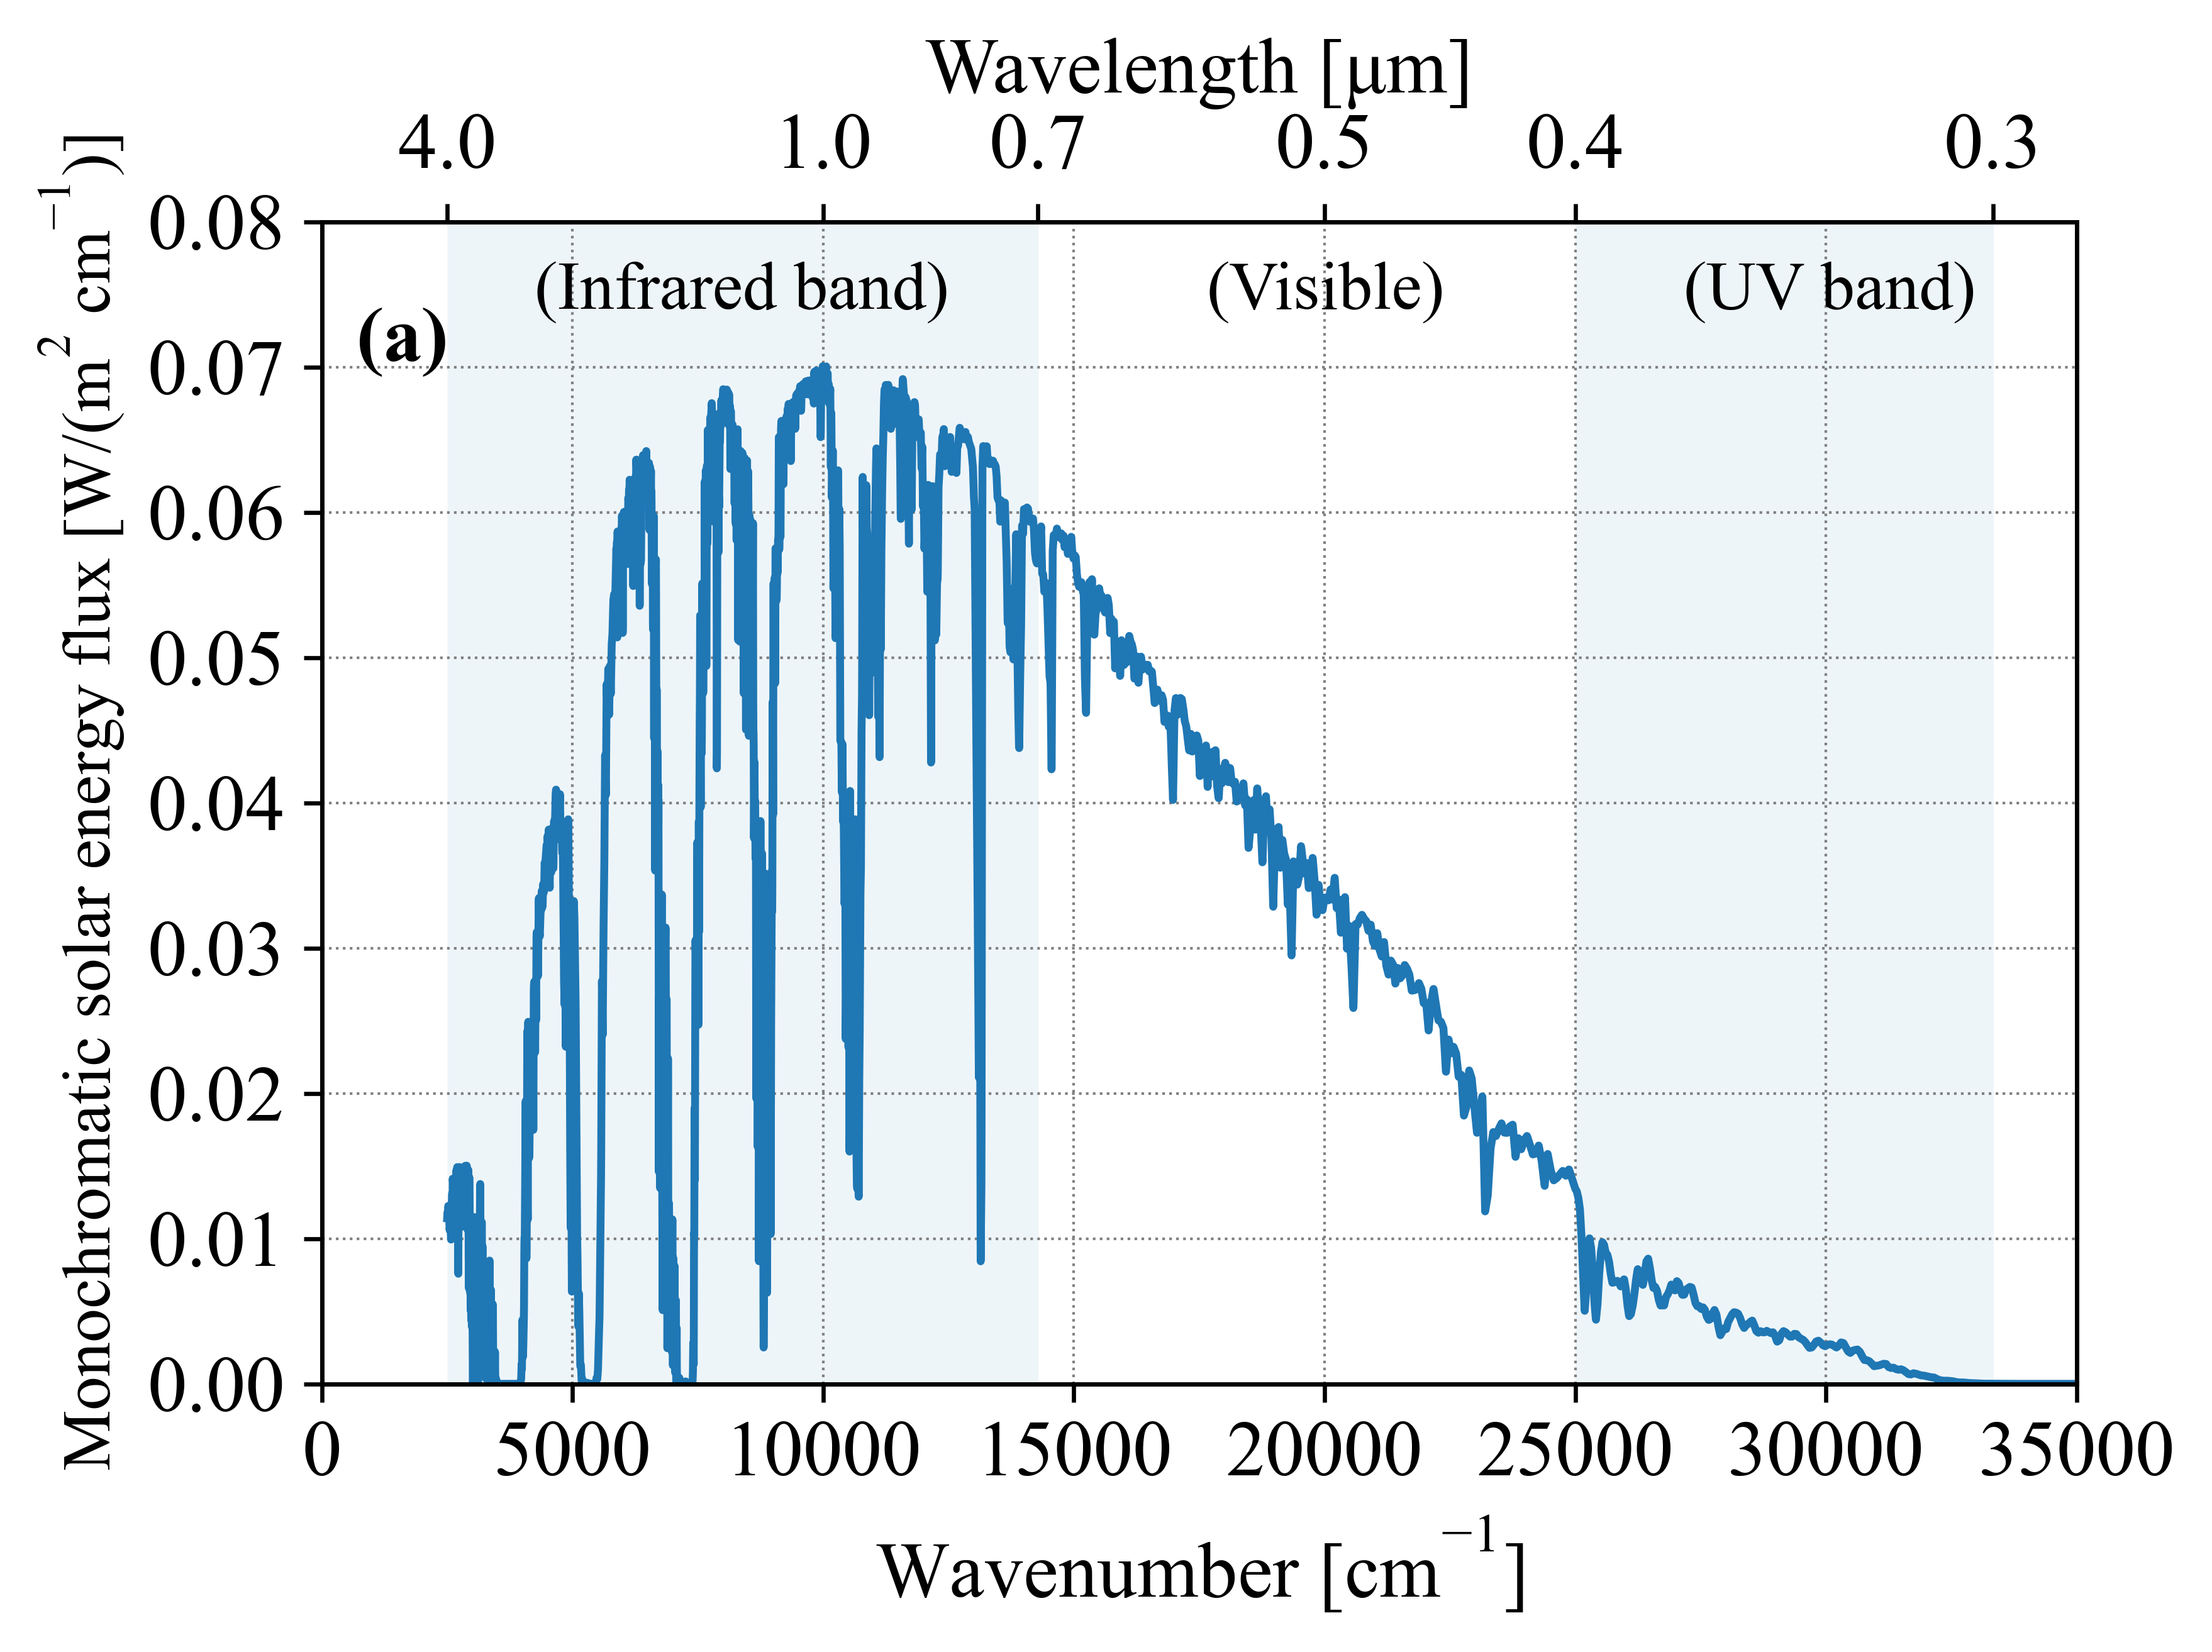

In [46]:
plt.rcParams['font.family'] = 'Times New Roman'  # For example, set font to Arial
plt.rcParams['font.size'] = 15  # 
# Create a figure of size y*y inches, 600 dots per inch
fig = plt.figure(figsize=(6, 4), dpi=600)
font=15
fontfml='Times New Roman'
gs1 = gridspec.GridSpec(1, 1)  # a grid with 1 row and 1 column
gs1.update(wspace=0.08, hspace=0.10) # set the spacing between axes.

ax1 = fig.add_subplot(gs1[0])
#ax1.plot(nu,F_dw_os,label="LW")
ax1.plot(nu2,F_dw_os2)#label="(a) shortwave")
#plt.legend(bbox_to_anchor=(1, 0.85),loc='right')

yticks=[c for c in np.arange(0.00,0.08+0.01,0.01, dtype=float)]
format_axes(ax1,(0,35000),(0,0.08),np.arange(0,35000+5000,5000),yticks,True,True,ylabel=[])
ax1.set_ylabel('Monochromatic solar energy flux [W/(m$^2$ cm$^{-1}$)]',fontsize=font-2,family=fontfml)
ax1.set_xlabel('Wavenumber [cm$^{-1}$]',fontsize=font,family=fontfml)
ax1.grid(True)
ax1.grid(color='grey', linestyle=':', linewidth=0.5)

# shading the bands
band_labels = ['(Infrared band)', '','(Visible)','(UV band)']
for j in range(0,len(bands)):
    nu_band=np.arange(bands[j][0],bands[j][1]+10,10)
    #if (j == 0 or j == 2):
     #   ax1.fill_between(nu_band,nu_band*0,nu_band*0+0.07,color='#a6cee3',linewidth=0,alpha=0.2)
    if (j == 1 or j == 3):
        ax1.fill_between(nu_band,nu_band*0,nu_band*0+0.08,color='#a6cee3',linewidth=0,alpha=0.2)  ##1f78b4
    if j == 3:
        ax1.text((bands[j][0]+bands[j][1])/2-2000,0.074,band_labels[j],fontsize=font-2,family=fontfml)
    if j == 2:
        ax1.text((bands[j][0]+bands[j][1])/2-2000,0.074,band_labels[j],fontsize=font-2,family=fontfml)
    if j == 0:
        ax1.text((bands[j][0]+bands[j][1])/2+3000,0.074,band_labels[j],fontsize=font-2,family=fontfml)

ax1.text(0.02, 0.88, '(a)', transform=ax1.transAxes,fontsize=font,fontfamily=fontfml, weight='bold')
# add another x-axis for wavelength
new_tick_locations = b_lims
ax3=lambda_axis(ax1,new_tick_locations,font,fontfml,True)
ax3.set_xlabel('Wavelength [μm]',fontsize=font,family=fontfml)

fig.savefig(fig_dir+'SW_spectrum.png', dpi=300, bbox_inches='tight',transparent=True)
plt.show()